In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import numpy as np 
from random import randrange

# Get user input

In [2]:
# function
def get_user_input():
    user_input = input('Enter song name').lower()
    
    return user_input

# Get top songs

In [3]:
# web scrapping

def get_top_songs():
    song_titles = []
    song_artists = []
    
    url = 'https://www.billboard.com/charts/hot-100'
    response = requests.get(url)
    response.status_code
    
    soup = BeautifulSoup(response.content, "html.parser")
    soup2 = soup.select('ol')
    # soup2 = soup.find_all('ol', {'class':'chart-list__elements'})

    for i in soup2[0].select('span.chart-element__information__song.text--truncate.color--primary'):
        song_titles.append(i.get_text().lower())
#     print(song_titles)

    for j in soup2[0].select('span.chart-element__information__artist.text--truncate.color--secondary'):
        song_artists.append(j.get_text().lower())   
    
    df_top_songs = pd.DataFrame({
    "song_title": song_titles,
    "song_artist": song_artists
    })
    
    return df_top_songs

In [4]:
# update df for newer 
# when: only when user inputs or every week - to be decided

def update_top_songs(df_top_songs):
    
    song_titles = []
    song_artists = []
    
    url = 'https://www.billboard.com/charts/hot-100'
    response = requests.get(url)
    response.status_code
    
    soup = BeautifulSoup(response.content, "html.parser")
    soup2 = soup.select('ol')

    for i in soup2[0].select('span.chart-element__information__song.text--truncate.color--primary'):
        song_titles.append(i.get_text().lower())

    for j in soup2[0].select('span.chart-element__information__artist.text--truncate.color--secondary'):
        song_artists.append(j.get_text().lower())   
    
    new_df_top_songs = pd.DataFrame({
    "song_title": song_titles,
    "song_artist": song_artists
    })    
    
    return df_top_songs.update(new_df_top_songs)

In [5]:
def recommend_another_top_song(df_top_songs, user_input):    
#     exclude user selected song
    songs_df_exclude_selected = df_top_songs[df_top_songs.song_title != user_input]
    
    random_song_index = np.random.choice(songs_df_exclude_selected.index,size =1)[0]

    return songs_df_exclude_selected.iloc[random_song_index,0], songs_df_exclude_selected.iloc[random_song_index,1]

In [6]:
df_top_songs = get_top_songs()

In [7]:
# run this every week
update_top_songs(df_top_songs)

# Part - Get features for songs in top songs

In [8]:
import sys
import import_ipynb

from config import *
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials

#Initialize SpotiPy with user credentias
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= Client_ID,
                                                           client_secret= Client_Secret))


importing Jupyter notebook from config.ipynb


In [9]:
# we get all the numerical features

In [10]:
def get_features(song):
    
    WAP = sp.search(q=song, limit=1) 

    WAP["tracks"]["items"][0]["uri"]

    features = sp.audio_features(WAP["tracks"]["items"][0]["uri"])

    selected_features = ["danceability", "energy","key","loudness",
                        'mode', 'speechiness', 'acousticness','instrumentalness',
                        'liveness','valence','tempo']
    
    #     returns a new dictionary    
    return {x: features[0][x] for x in selected_features } 


In [11]:
# get features for 100 songs 

def add_features_to_df(df):
    
    #     loop through data frame col song_title
    songs_features = []
    
    for i in df['song_title']:
        songs_features.append(get_features(i))
    
    features_df = pd.DataFrame(songs_features)
    
    #     returns df
    return pd.concat([df, features_df], axis = 1)
    


In [12]:
# store features df in a csv

def export_to_csv(df_top_songs_features):
    df_top_songs_features.to_csv('top_songs_features.csv', index=False)



In [13]:
df_top_songs_with_features = add_features_to_df(df_top_songs)

In [14]:
# check types of df
df_top_songs_with_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_title        100 non-null    object 
 1   song_artist       100 non-null    object 
 2   danceability      100 non-null    float64
 3   energy            100 non-null    float64
 4   key               100 non-null    int64  
 5   loudness          100 non-null    float64
 6   mode              100 non-null    int64  
 7   speechiness       100 non-null    float64
 8   acousticness      100 non-null    float64
 9   instrumentalness  100 non-null    float64
 10  liveness          100 non-null    float64
 11  valence           100 non-null    float64
 12  tempo             100 non-null    float64
dtypes: float64(9), int64(2), object(2)
memory usage: 10.3+ KB


In [15]:
export_to_csv(df_top_songs_with_features)

# Part - creating clusters for top songs

In [16]:
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [17]:
# Load data
X = pd.read_csv('top_songs_features.csv')

In [18]:
X_features = X.drop(['song_title','song_artist'],axis=1)
X_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.700,0.722,7,-3.558,0,0.0369,0.22100,0.000000,0.2720,0.756,90.989
1,0.889,0.340,11,-7.773,0,0.0697,0.21800,0.130000,0.0550,0.716,94.009
2,0.737,0.802,0,-4.771,1,0.0878,0.46800,0.000000,0.0931,0.682,144.015
3,0.466,0.536,6,-6.227,1,0.0429,0.09510,0.000000,0.1140,0.377,75.998
4,0.761,0.518,0,-8.871,1,0.1340,0.24400,0.000035,0.1070,0.522,133.976
...,...,...,...,...,...,...,...,...,...,...,...
95,0.954,0.696,10,-7.117,0,0.2040,0.00576,0.000498,0.0754,0.432,100.036
96,0.867,0.517,2,-6.914,1,0.3070,0.01160,0.000000,0.3100,0.271,143.043
97,0.877,0.607,10,-7.818,0,0.1500,0.53500,0.000000,0.1380,0.773,127.055
98,0.849,0.536,1,-7.307,1,0.3490,0.02390,0.000000,0.1260,0.308,141.964


In [19]:
# transform data to same scale
# variables to be used throughout

scaler = StandardScaler()
X_prep = scaler.fit_transform(X_features)

X_transformed = pd.DataFrame(X_prep, columns = X_features.columns)

## Clustering with K-Means

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

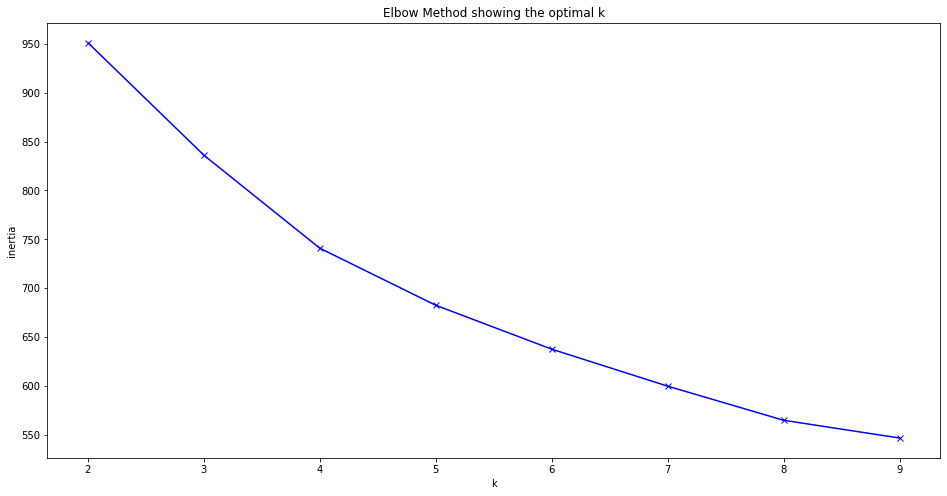

In [21]:
def check_best_k_value(X_prep):
    
    K = range(2, 10)
    inertia = []

    for k in K:
        kmeans = KMeans(n_clusters=k,
                        random_state=1234)
        
        kmeans.fit(X_prep)

        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(16,8))
    plt.plot(K, inertia, 'bx-')

    plt.xlabel('k')
    plt.ylabel('inertia')

    plt.xticks(np.arange(min(K), max(K)+1, 1.0))
    plt.title('Elbow Method showing the optimal k')
    
check_best_k_value(X_prep)

In [22]:
# It seems that k =4 is the elbow

## Silouhette

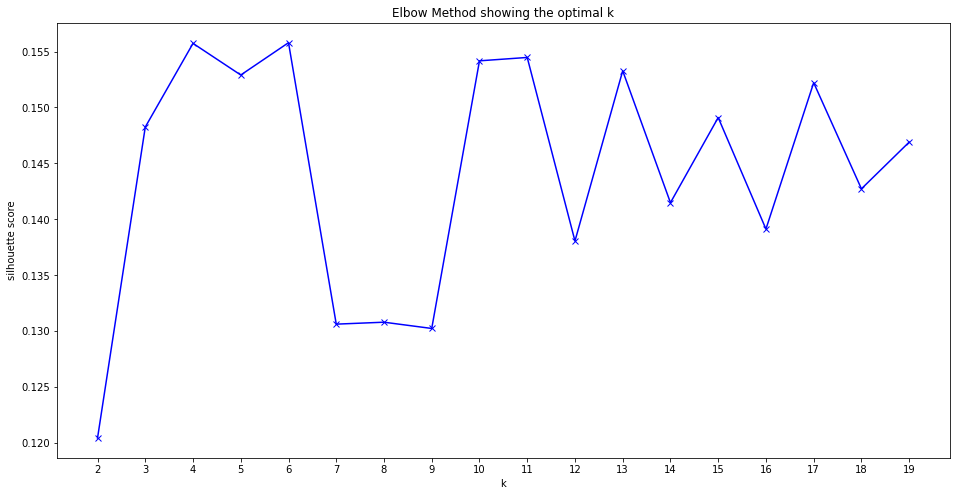

In [23]:
def check_silouhette_scores(X_prep):
    
    K = range(2, 20)
    silhouette = []

    for k in K:
        kmeans = KMeans(n_clusters=k,
                        random_state=1234)

        kmeans.fit(X_prep)

        silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))

    plt.figure(figsize=(16,8))
    plt.plot(K, silhouette, 'bx-')
    plt.xlabel('k')
    plt.ylabel('silhouette score')
    plt.xticks(np.arange(min(K), max(K)+1, 1.0))
    plt.title('Elbow Method showing the optimal k')
    
check_silouhette_scores(X_prep)

The greater the Silouhette, the greater the separation between the clusters, In other words, the clusters will be more defined.

4 and 6 seems to be the highest scores, 4 is chosen because it coincides with above value of k at elbow 

In [24]:
n_clusters = 4

In [25]:
# assign the clusters 
def assign_clusters(X_prep, n_clusters):
    
    kmeans = KMeans(n_clusters, random_state=1234)
    
    kmeans.fit(X_prep)
    
    clusters = kmeans.predict(X_prep)
    values = pd.Series(clusters).value_counts().sort_index()
    
    X_df = pd.DataFrame(X)
    X_df["cluster"] = clusters
    X_df.head()  
    
    return X_df, kmeans
    


In [26]:
X_df, kmeans = assign_clusters(X_prep, n_clusters)    

# Part - Process 'not hot' song (find features and recommend similar song)

In [27]:
# get features, get cluster, recommend similar song in cluster

def get_features_for_song(song):
    song_features = get_features(song)
    
#     returns df with features only
    return pd.DataFrame([song_features])
    

In [28]:
def predict_cluster(df_song_features, scaler, n_clusters):
    song_features_transformed = scaler.transform(df_song_features)
    
    return kmeans.predict(song_features_transformed)[0]
    


In [29]:
# filter the top songs to only predicted cluster

def filter_cluster(X_df, cluster):
#     print(X_df[X_df['cluster'] == cluster].shape)
    return X_df[X_df['cluster'] == cluster]


In [30]:
#  return random song from cluster

def recommend_random_song_from_cluster(X_df_cluster, df_top_songs):
    
    random_song_index = randrange(len(X_df_cluster))
    random_song_name = X_df_cluster.iloc[random_song_index,0]
    
    random_song_artist = df_top_songs.loc[df_top_songs['song_title'] == random_song_name].iloc[0,1]

    return random_song_name, random_song_artist


In [31]:
# put everything together

# take example 
# user_input = 'Mirrors'

def check_if_hot_song(user_input, df_top_songs):
    
    if user_input in df_top_songs['song_title'].values:
        random_top_song, random_top_song_artist = recommend_another_top_song(df_top_songs, user_input)
        
        print(f"Let me recommend another hot song: {random_top_song} by {random_top_song_artist}", )
        
    else:
        print('Let me find audio features of this song and recommend a similar top song:')
        
        df_song_features = get_features_for_song(user_input)
        
        cluster = predict_cluster(df_song_features, scaler, n_clusters)

        X_df_cluster = filter_cluster(X_df, cluster)
        
        random_song_name,random_song_artist = recommend_random_song_from_cluster(X_df_cluster, df_top_songs)
        
        print(f"{random_song_name} by {random_song_artist}") 
        
     

In [32]:
def init():
    user_input = get_user_input()  
#     print(f"Song you entered: {user_input} " )

    check_if_hot_song(user_input, df_top_songs)




In [34]:
init()

Enter song name mirror


Song you entered: mirror 
Let me find audio features of this song and recommend a similar top song:
heather by conan gray
